# Task 1.   To review Chapters 14 of Raschka book  and submit one jupyter notebook as a tutorial to train deep convolutional neural networks with pytorch

In [1]:
!pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [2]:
import torch
print('PyTorch version:', torch.__version__)

PyTorch version: 2.0.0+cu117


# The building blocks of CNNs
Convolutional Neural Networks (CNNs) are a family of models that were originally inspired by how the visual cortex of the human brain works when recognizing objects.

## Understanding CNNs and feature hierarchies
CNNs can automatically learn the features from raw data that are most useful for a particular class. Because of this, CNN layers can be considered as feature extractors.

CNNs usually performs very well on image-related tasks because of two reasons.
- Sparse connectivity: single element in the feature map is connected to only a small patch of pixels
- Parameter sharing: same weights are used for different parts of the input image

As a direct consequence of these two ideas, replacing a conventional, fully connected multilayer perceptron (MLP) with a convolution layer substantially decreases the number of weights which causes an improvement in the ability to capture salient features.

CNNs are typically composed of several convolutional and sub-sampling layers that are followed by one or more fully connected layers in the end.

In the following example, a convolution in one dimention will be studied before working through a typical two-dimensional CNN that are commonly applied to 2D images.

## Performing discrete convolutions
A discrete convolution is a fundamental operation in a CNN.

### Discrete convolutions in one dimension
A discrete convolution for two vectors (x and w) can be denoted by y = x * w, in which vector (x) is the input, (w) is the filter/kernel, and (y) is the output vector.

The interesting thing is that the sum of the vectors can be a negative to positive infinite value, which may be misleading as machine learning applications tend to deal with finite feature vectors. However, this is the case because it is assumed that (x) and (w) are filled with zeros. This process is called zero-padding.

Another issue is indexing x with i + m - k. For that, simply compute the dot product. 

### Padding inputs to control the size of the output feature maps
Padding can be applied with any number greater than or equal to zero. There are three modes of padding that are commonly used in practice: full, same, and valid.

In full mode, the padding parameter (p) is set to p = m - 1. Full padding increases the dimensions of the output. Thus, it is rarely used in CNN architectures.

The same mode is usually used to ensure that the output vector has the same size as the input vector. In this case, the padding parameter is computed according to the filter size.

Lastly, in valid mode it refers to the case where p = 0 (no padding).

The most commonly used padding mode in CNNs is same padding. The advantage is that same padding preserves the size of the vector which makes designing a network architecture more convenient. Conversely, one disadvantage of valid padding is that the volume of the tensors will decrease substantially in NNs with many layers. Therefore, in practice, the spatial size is usually preserved with the same padding for the convolutional layers. 

As for full padding, its size results in an output larger than the input size.

### Determining the size of the convolution output

In [3]:
# compute convolutions in one dimension
import numpy as np
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([
            zero_pad, x_padded, zero_pad
        ])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot))) + 1, s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]
print('Conv1d Implementation:', 
     conv1d(x, w, p=2, s=1))
print('NumPy Results:',
     np.convolve(x, w, mode='same'))

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
NumPy Results: [ 5 14 16 26 24 34 19 22]


### Performing a discrete convolution in 2D

In [4]:
# implement the 2D convolution
import scipy.signal

def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))
print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## Subsampling layers
Subsampling is typically applied in two forms of pooling operations in CNNs (max-pooling and mean-pooling).
The advantages of pooling are as follows:
- Pooling (max-pooling) introduces a local invariance. This means that small changes in a local neighborhood does not change the result of max-pooling. 
- Pooling decreases the size of features, which results in higher computational efficiency.

While pooling is still an essential part of many CNN architectures, several CNN architectures have also been developed without using pooling layers.

## Putting everything together - implementing a CNN
CNNs are similar to traditional multilayer NNs, except that the matrix multiplication step is replaced by a convolution operation. However, in both cases, the pre-activations are passed to an activation function to obtain the activation of a hidden unit.

### Working with multiple input or color channels
An input to a convolutional layer may contain one or more 2D arrays or matrices with dimensions N1*N2. These matrices are called channels. 

For example, consider images as input to the first layer of a CNN. If the image is colored and uses the RGB color mode, then the number of input channels equals to 3, one for each of the color channels in RGB. However, if the image is grayscale, then the number of channels will be equal to 1, because there is only one channel with grayscale pixel intensity values.

How can multiple input channels be incorporated? This is done by performing the convolution operation for each channel separately before adding the results together using the matrix simmation.

### Regularizing an NN with L2 regularization and dropout
Choosing the size of a network, whether dealing with a traditional NN or a CNN, has always been a challenging problem. 

Recall that a simple network without a hidden layer could only capture a linear decision boundary, which is not sufficient for dealing with an exclusive (XOR) or similar problem. Small networks, or networks with small number of parameters, have a low capacity and are therefore likely to underfit, resulting in poor performance. However, very large networks may result in overfitting, where the network will memorize the training data and do extremely well ont he training dataset while achieving a poor performance on the test dataset. 

Therefore, one way to address this problem is to build a network with a relatively large capacity to do well on the training dataset. Then, to prevent overfitting, one or more regularization schemes can be implemented to achieve good generalization performance on new data.

In [5]:
# use L2 regularization within a CNN 
import torch.nn as nn
loss_func = nn.BCELoss()
loss = loss_func(torch.tensor([0.9]), torch.tensor([1.0]))
l2_lambda = 0.001

conv_layer = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in conv_layer.parameters()])
loss_with_penalty = loss + l2_penalty

linear_layer = nn.Linear(10, 16)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in linear_layer.parameters()])
loss_with_penalty = loss + l2_penalty

In recent years, dropout has became a popular technique for regularizing (deep) NNs to avoid overfitting, thus improving the generalization performance. Dropout is usually applied to the hidden units of higher layers. When dropping a certain fraction of input neurons, the weights associated with the remaining neurons are rescaled to account for the missing (dropped) neurons.

The basic idea is to randomly drop out (set to zero) some of the units in the neural network during training, which forces the network to learn redundant representations and can help prevent overfitting. Essentially, the network becomes more generalizable by preventing it from relying too heavily on specific nodes or features that may be present in the training data but not in new data.

However, since it is inconvenient to always scale activations when making predictions, PyTorch and other tools scale the activations during training. This approach is commonly referred to as inverse dropout. This is essentially a workaround which is an efficient way to train many models at once and compute their average predictions at test or prediction time.

## Loss functions for classification
Recall activation functions: ReLU, sigmoid, and tanh.
Some of these activation functions, like ReLU, are mainly used in the hidden layers of an NN to add non-linearities to the model. For others like sigmoid (for binary) and softmax (for multiclass), they are added at the output layer, which results in class-membership probabilities as the output of the model.

Focusing on classification problems, the appropriate loss function would be binary cross-entropy for binary classification and categorical cross-entropy for multiclass classification.

Computing cross-entropy loss by providing the logits, and not the class-membership probabilities is usually preferred due to numerical stability.

In [6]:
# use binary cross-entropy as loss function
logits = torch.tensor([0.8])
probas = torch.sigmoid(logits)
target = torch.tensor([1.0])

bce_loss_fn = nn.BCELoss()
bce_logits_loss_fn = nn.BCEWithLogitsLoss()

print(f'BCE (w Probas): {bce_loss_fn(probas, target):.4f}')
print(f'BCE (w Logits): {bce_logits_loss_fn(logits, target):.4f}')

BCE (w Probas): 0.3711
BCE (w Logits): 0.3711


In [7]:
# use categorical cross-entropy as loss function
logits = torch.tensor([[1.5, 0.8, 2.1]])
probas = torch.softmax(logits, dim=1)
target = torch.tensor([2])

cce_loss_fn = nn.NLLLoss()
cce_logits_loss_fn = nn.CrossEntropyLoss()

print(f'CCE (w Logits): {cce_logits_loss_fn(logits, target):.4f}')
print(f'CCE (w Probas): {cce_loss_fn(torch.log(probas), target):.4f}')

CCE (w Logits): 0.5996
CCE (w Probas): 0.5996


# Implementing a deep CNN using PyTorch

## Loading and preprocessing the data

In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split

In [9]:
# load MNIST dataset and construct training and test sets
import torchvision
from torchvision import transforms 
image_path ='./'
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                          train=True,
                                          download=False)
from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                               train=False,
                                               transform=transform,
                                               download=False)

As seen from above, the MNIST dataset comes with pre-specified training and test dataset partitioning. However, a validation split was also created. Therefore, the first 10000 training examples were used for validation.

Next, the data loader with batches of 64 images for the training set and validation set will be constructed.

In [10]:
# construct data loader with 64 image batch size for train and valid sets
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset,
                     batch_size,
                     shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset,
                    batch_size,
                    shuffle=False)

## Based on what you learned in Task 2 of HW8, develop a deep neural network model to classify MNIST handwritten digits

In [11]:
# load MNIST dataset using torchvision
image_path = './'
transform = transforms.Compose([
        transforms.ToTensor()
])

mnist_dataset = torchvision.datasets.MNIST(
        root=image_path, train=True,
        transform=transform, download=False
)

train_size = 45000
val_size = 10000
test_size = len(mnist_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(mnist_dataset, [train_size, val_size, test_size])

In [12]:
# print length of each dataset
print('Training set size: ', train_size)
print('Validation set size: ', val_size)
print('Test set size: ', test_size)

Training set size:  45000
Validation set size:  10000
Test set size:  5000


In [13]:
# construct NN model -- Trial 1
hidden_units = [32, 16]
image_size = mnist_dataset[0][0].shape
input_size = image_size[0] * image_size[1] * image_size[2]

all_layers = [nn.Flatten()]
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 10))
model = nn.Sequential(*all_layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=10, bias=True)
)

In [14]:
# define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
# define training function
def train(model, train_dl, loss_fn, optimizer, epochs=20):
    for epoch in range(epochs):
        for batch in train_dl:
            images, labels = batch
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

In [16]:
# function call
batch_size = 128
train_dl = DataLoader(train_ds, batch_size)
val_dl = DataLoader(val_ds, batch_size)
train(model, train_dl, loss_fn, optimizer)

Epoch 1/20, Loss: 0.5111
Epoch 2/20, Loss: 0.3931
Epoch 3/20, Loss: 0.3274
Epoch 4/20, Loss: 0.2790
Epoch 5/20, Loss: 0.2308
Epoch 6/20, Loss: 0.1841
Epoch 7/20, Loss: 0.1507
Epoch 8/20, Loss: 0.1257
Epoch 9/20, Loss: 0.1133
Epoch 10/20, Loss: 0.0998
Epoch 11/20, Loss: 0.0892
Epoch 12/20, Loss: 0.0830
Epoch 13/20, Loss: 0.0751
Epoch 14/20, Loss: 0.0668
Epoch 15/20, Loss: 0.0603
Epoch 16/20, Loss: 0.0534
Epoch 17/20, Loss: 0.0483
Epoch 18/20, Loss: 0.0432
Epoch 19/20, Loss: 0.0415
Epoch 20/20, Loss: 0.0387


In [17]:
# evaluate model on test set
def evaluate(model, test_dl):
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in test_dl:
            images, labels = batch
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
        print(f"Accuracy: {correct/total:.4f}")

evaluate(model, val_dl)

Accuracy: 0.9590


## To develop a deep CNN model to classify MNIST handwritten digits

In [18]:
# load MNIST dataset and construct training and test sets
import torchvision 
from torchvision import transforms 
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=False, 
                                           transform=transform, 
                                           download=False)

In [19]:
# construct data loader with 64 image batch size for train and valid sets
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

In [20]:
# construct a CNN
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32,
                                   kernel_size=5, padding=2))

model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64,
                                   kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

So far, two convolution layers have been added to the model. For each convolution layer, kernel size of 5x5 and padding=2 was used. As mentioned before, using same padding mode preserves the spatial dimensions of the feature maps such that the inputs and outputs have the same height and width.

In [21]:
# calculate the size of the feature maps
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

This indicates there are feature maps with 64 channels with a spatial size of 7x7. The first dimension corresponds to the batch dimension, for which 4 was used arbitrarily.

In [22]:
# flatten the output of previous layers to add fully connected layer
model.add_module('flatten', nn.Flatten())
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

This indicates that the input dimensions for the fully connected layer are correctly set up.

Next, two fully connected layers with a dropout layer in between will be added.

## To explore how dropout would affect CNN model’s performance

In [23]:
# add a dropout layer between the two fully connected layers
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))

In [24]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

model = model.to(device) 

In [25]:
# define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
# define function to train model 
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()
            
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [27]:
# train CNN model and use valid set to monitor learning process
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9504 val_accuracy: 0.9823
Epoch 2 accuracy: 0.9838 val_accuracy: 0.9877
Epoch 3 accuracy: 0.9895 val_accuracy: 0.9851
Epoch 4 accuracy: 0.9920 val_accuracy: 0.9890
Epoch 5 accuracy: 0.9925 val_accuracy: 0.9903
Epoch 6 accuracy: 0.9945 val_accuracy: 0.9882
Epoch 7 accuracy: 0.9949 val_accuracy: 0.9911
Epoch 8 accuracy: 0.9959 val_accuracy: 0.9892
Epoch 9 accuracy: 0.9963 val_accuracy: 0.9907
Epoch 10 accuracy: 0.9971 val_accuracy: 0.9909
Epoch 11 accuracy: 0.9970 val_accuracy: 0.9903
Epoch 12 accuracy: 0.9973 val_accuracy: 0.9910
Epoch 13 accuracy: 0.9978 val_accuracy: 0.9887
Epoch 14 accuracy: 0.9975 val_accuracy: 0.9895
Epoch 15 accuracy: 0.9980 val_accuracy: 0.9903
Epoch 16 accuracy: 0.9977 val_accuracy: 0.9900
Epoch 17 accuracy: 0.9979 val_accuracy: 0.9918
Epoch 18 accuracy: 0.9981 val_accuracy: 0.9902
Epoch 19 accuracy: 0.9986 val_accuracy: 0.9894
Epoch 20 accuracy: 0.9982 val_accuracy: 0.9899


Text(0, 0.5, 'Accuracy')

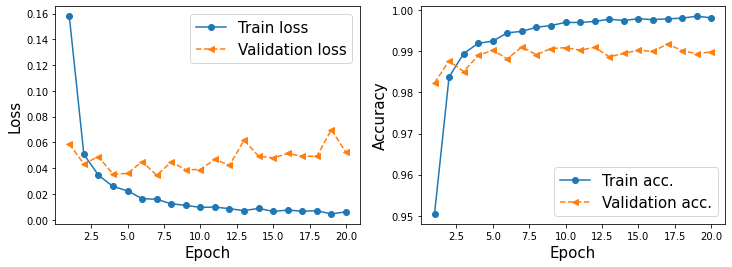

In [28]:
import matplotlib.pyplot as plt


x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

In [ ]:
# evaluate trained model on test dataset
torch.cuda.synchronize()
model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Kernel dies when running the above code. CNN model achieves an accuracy of ~99.14% with the dropout layer between convolutional layers.

This is compared with getting ~95% accuracy using only fully connected layers.